# 4 point Thermometry Analysis ONLY

This script will be used purely to analyse the results of the 4 point ODMR measurements using only the temperature sensing algorithms as defined in the papers:
1. Singam et al (2019) - Nitrogen-vacancy nanodiamond based local thermometry using frequency-jump modulation
2. Fujiwaraet al (2020) - Real-time nanodiamond thermometry probing in vivo thermogenic responses. 

The aim of writing this script is to tidy up the original frankenstien script currently at the time of writing called: 
20210617_Analysis_Referenced_4_point_ODMR.ipynb

Unfortunately, I think I need to call in basically all the same functions and perform basically all the same analysis, but I will have fewer outputs and will structure everything a little bit nicer so that I can run everything from a single "main" cell at the bottom of the script and know that everything will get pulled in properly... I might have it so that any full CW ODMR script analysis is done in a separate cell just so I don't end up bogging down the whole script everytime it runs. 

In [1]:
import scipy.optimize as opt 
import numpy as np 
import matplotlib.pyplot as plot 
import os 
import pandas as pd
from scipy.signal import find_peaks

Pull in the data files and the associated params file. Also make the plots big enough to actually be able to see what's going on and read what's on the graphs. 

In [2]:
def load_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = np.loadtxt(file_path)
    return(data_array)

In [3]:
def load_params(file_path):
    # load in the params data. 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

In [4]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

Creates a numpy array with the microwave frequency scan range from the params file. 

In [5]:
def create_freq_scan(start, stop, step_size):
    # takes the scan parameters from the params data file. 
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    return(freq)

Here we have the code to reshape the ODMR data into a 3D dataset according to the parameters that are given in the Params.txt file. 

Once the ODMR and reference Datasets have been restructured, then we can perform the normalisation of the ODMR dataset to the reference dataset.  

In [6]:
def reshape_data(reference_data, odmr_data, params_values):
    '''Here we re-shape the reference and the ODMR datasets into a 3D array, 
    based on the number of line scans, frequnecy points and repeats per frequnecy 
    have been used to build the ODMR dataset.'''
    
    # Create variables with the frequnecy scan parameters. 
    num_of_line_scans = int(params_values[4])
    num_of_freqs =  int(1000*(params_values[1]-params_values[0])/params_values[2]) + 1
    points_per_freq = int(params_values[8])
    print(num_of_line_scans, num_of_freqs, points_per_freq)
    # Reshape the ODMR and reference datasets. 

    odmr_shape_3D = odmr_data[0:num_of_freqs*points_per_freq].reshape(num_of_line_scans, num_of_freqs, points_per_freq)
    reference_data_3D = reference_data[0:num_of_freqs*points_per_freq].reshape(num_of_line_scans, num_of_freqs, points_per_freq)
    
    return(odmr_shape_3D, reference_data_3D)

In [7]:
def normalise_data(reference_data, odmr_data):
    '''Here we normalise the ODMR dataset to the reference data.'''

    norm_odmr_data = odmr_data/reference_data
    return(norm_odmr_data)

Find the mean of the ODMR dataset.

In [8]:
def mean_data(odmr_data):
    # find the mean data 
    mean_odmr_data_points =  np.mean(odmr_data, axis = 2)
    mean_odmr_data_points_and_linescans =  np.mean(mean_odmr_data_points, axis = 0)
    return(mean_odmr_data_points, mean_odmr_data_points_and_linescans)

Plot the Normalised ODMR data to a graph.

In [9]:
def normalised_scatter_plot(freq, mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    
    ax2.set_xlim(np.min(freq),np.max(freq))
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Normalised Counts (A.U.)', fontsize = 18)
    return(fig2, ax2)

Get the fitting parameters from the ODMR dataset and use these to fit a double Lorentzian lineshape to the normalised ODMR dataset.

In [10]:
def get_init_params(odmr_data, freq):
    # find the minima of the ODMR spectra and ODMR dip contrast and 
    # flourenscent baseline.
    
    half_data_length = int((len(freq)-1)/2) # This brings the mid-value to 2.87GHz 
    
    #find the indices for the lowest frequency value
    low_freq_min_index = np.where(odmr_data[0:half_data_length] == np.min(odmr_data[0:half_data_length]))
    high_freq_min_index = np.where(odmr_data[half_data_length:len(odmr_data)-1] == 
                                   np.min(odmr_data[half_data_length:len(odmr_data)-1]))
   
    # frequencies corresponding to ODMR minima
    freq_mins = [np.float(freq[low_freq_min_index[0]]),
                 np.float(freq[high_freq_min_index[0]+half_data_length])]
    
    # manually set frequencies. 
    
    #freq_mins = [2.78, 2.96]
    
    flourescent_baseline = np.mean(odmr_data)
    
    # approximate dip_depth
    dip_depth = [odmr_data[low_freq_min_index[0][0]]  - flourescent_baseline, 
                 odmr_data[high_freq_min_index[0][0]+half_data_length]  - flourescent_baseline]
    
    #contrast = [np.float((1-odmr_data[low_freq_min_index[0]]/flourescent_baseline)), 
    #            np.float((1-odmr_data[high_freq_min_index[0]+half_data_length]/flourescent_baseline))]

    return(freq_mins, dip_depth, flourescent_baseline)

In [11]:
def optimised_lorentz_fit(freq, mean_data, init_params, lower_bounds, upper_bounds):
    # A method to find the fitting prameters for the ODMR dataset. 
    y_error = np.sqrt(mean_data) # poissonian noise
    coeffs, confidence = opt.curve_fit(double_lorentz, freq, mean_data, init_params, 
                                       sigma = y_error, bounds = (lower_bounds, upper_bounds))
    opt_error = np.sqrt(np.diag(confidence))
    
    return(coeffs, opt_error)

In [12]:
def double_lorentz(x, A1, X01, sig1, A2, X02, sig2, offset): #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
    # A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return (first_peak + second_peak + offset)

In [13]:
def plot_fitting(ax2, freq, dwell_time):
    # plot the y fit. 
    
    high_res_freq = np.linspace(freq[0], freq[len(freq)-1], 10*len(freq)+1)
    
    # create the double lorentz fit array
    y_fit_high_res = double_lorentz(high_res_freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    y_fit = double_lorentz(freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    ax2.plot(high_res_freq, y_fit_high_res, color='k', label='Double Lorentz \nfitting')
    ax2.legend()
    
    return(ax2, y_fit)

*************************************************************************************************************************************************************************************

### Full CW ODMR Analysis

This should be a fairly base level referenced ODMR dataset analysis. From this, we should be able to reshape, normalise and plot the ODMR data.  
Additionally, I should be able to extract the Double Lorentz fitting of the dataset as it is needed for some of the further analysis.

*****************************************************************

1 61 100
[2.8649999999999998, 2.8739999999999997]
25000.0
0.01451626153985382 0.01250285927773438
19133.638196721313


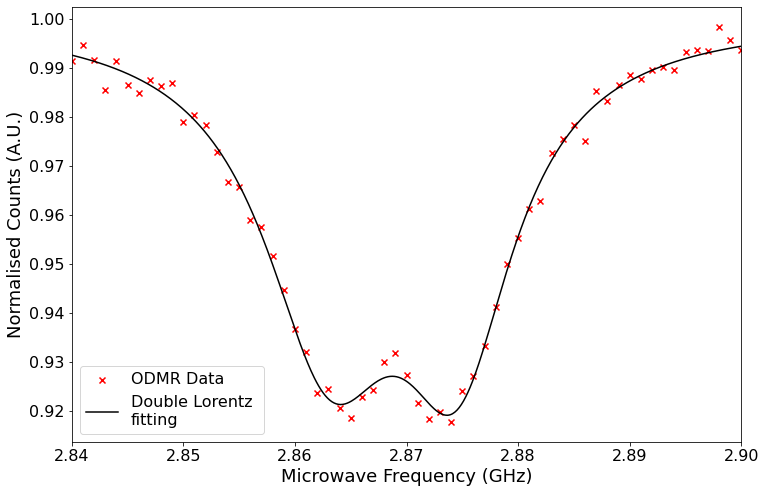

In [27]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
 # Saves this data into a text file and the 2 plots generated. 
#######

date = '20210930' # Date on folder in which the experimental data is saved. 
set_plot_params()

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\2021\\' + date + '\\'
#folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\Imaging\\'

data_set = '_referenced_odmr_14' # Short hand for the file name. 

# Set the file names for all 4 data sets recorded from the experiment. 
file_name_ODMR1 = date + data_set + '_ODMR1.dat'
file_name_ODMR2 = date + data_set + '_ODMR2.dat'
file_name_Ref1 = date + data_set  + '_Ref1.dat'
file_name_Ref2 = date + data_set  + '_Ref2.dat'

# Extract the ODMR and reference datasets from the data we are looking at. 
odmr_data = load_data(folder_path + file_name_ODMR1)
reference_data = load_data(folder_path + file_name_Ref1)

# Get the parameters for the experiment. 
params_file = load_params(folder_path + date  + data_set + '_Params.txt')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
# Freq scan = frequency scan actually used in experiment, frreq = scan without triggering problems. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])

# Dwell time of the measurment 
dwell_time = params_values[3]

# Reshape the ODMR and reference datasets. 
odmr_data, reference_data = reshape_data(reference_data, odmr_data, params_values)

# Normalise the ODMR data against the reference data. 
normalised_ODMR = normalise_data(reference_data, odmr_data)

# Mean of the normalise dataset. 
# mean_odmr_freq_points = mean for all the points recorded per frequnecy, but not linescans. 
# mean_norm_odmr_full = Mean fluorescence value for all ODMR data points taken per freq. 
mean_odmr_freq_points, mean_norm_odmr_full_disordered = mean_data(normalised_ODMR)
mean_norm_odmr_full = np.roll(mean_norm_odmr_full_disordered, 1)

# Plot the mean normalised dataset as a scatter plot. 
fig1, ax1 = normalised_scatter_plot(freq, mean_norm_odmr_full)

# find the freqeuncy points with the highest ODMR contrast
freq_mins, dip_depth, flourescent_baseline = get_init_params(mean_norm_odmr_full, freq)
print(freq_mins)


# create the initial parameters for ODMR double lorentzian 
# line fitting
init_params = [dip_depth[0], freq_mins[0], 0.005, dip_depth[1], freq_mins[1], 0.005, flourescent_baseline]
init_params = [-0.8, 2.86, 0.005, dip_depth[1], 2.87, 0.005, flourescent_baseline]

# Set the upper and lower bounds for the fitting algorithm. 
lower_bounds = [-np.inf, init_params[1] - 0.01, 0, -np.inf, init_params[4] - 0.01, 0, 0]
upper_bounds = [np.inf, init_params[1] + 0.01, 1, np.inf, init_params[4] + 0.01, 1, np.inf]

# generate the optimised curve fit parameters. 
fitting_params, error_in_fit = optimised_lorentz_fit(freq, mean_norm_odmr_full, init_params,
                                                    lower_bounds, upper_bounds)

# plot the fitting to ax1
ax1, y_fit = plot_fitting(ax1, freq, params_values[3])
print(dwell_time)
print(fitting_params[2], fitting_params[5])
print(np.mean(reference_data))

***

### Begin the 4 point ODMR Analysis

Here I plan to:
1. Read in the 4 point ODMR data and the corresponding reference dataset.
2. Plot the normalised 4 point ODMR dataset against the fitted double Lorentz curve along with the intensitied of the 4 frequency points as expected from the fitted curve. 
3. Perform the analysis of the 4 point ODMR data using the method propsed by Fujiwara et al (2020).
4. perform the analysis of the 4 point ODMR dataset using the method proposed by Singam et al (2019). 

I will aim to make both the analysis methods such that it can take both a single mean value from the dataset and can analyse the full dataset to give a mean value for the T (or $\delta$D) and the standard deviation in the recorded values. This allows us to apply an error value to the recorded datapoints, which is probably a good thing.  

In [15]:
def normalise_data_error_propogation(norm_odmr_4_point, four_point_reference_data, four_point_odmr_data, repeats):
    '''Calculating the error associated with each of the individual repeats of the 4 frequnecy points in the dataset.'''
    
    mean_norm_4_point_intensity = np.mean(four_point_odmr_data, axis = 2)
    mean_norm_4_point_ref_intensity = np.mean(four_point_reference_data, axis = 2)
    
    delta_I_odmr = (2.2 * np.sqrt(mean_norm_4_point_intensity))/(mean_norm_4_point_intensity*np.sqrt(repeats))
    delta_I_ref = (2.2 * np.sqrt(mean_norm_4_point_ref_intensity))/(mean_norm_4_point_ref_intensity*np.sqrt(repeats))
    
    delta_I_normalised = norm_odmr_4_point * np.sqrt(delta_I_odmr**2 + delta_I_ref**2)
    
    return(delta_I_normalised)

In [16]:
def fujiwara_analysis(four_freqs, mean_norm_4_point_odmr_full, error_four_points):
    '''Here we perform the analysis of the 4 point ODMR dataset using the method outlined in Fujiwara's paper from 2020'''
    
    # Find the frequency step (delta omega) used to split the 4 points away from the mid-point of the linear portion of the ODMR curve fitting. 
    freq_step = 0.5*((four_freqs[1]-four_freqs[0])*1000) # MHz conversion
    
    # The expected dD/dT from the paper published by Acosta et al 2013. 
    delta_D_delta_T = -0.075 # MHz/K
    
    # Calculate the numerator and denomiator for the equation used to determine the $\delta$ T for this experiment 
    numerator = (mean_norm_4_point_odmr_full[0] + mean_norm_4_point_odmr_full[1]) - (mean_norm_4_point_odmr_full[2] + mean_norm_4_point_odmr_full[3])
    denominator = (mean_norm_4_point_odmr_full[0] - mean_norm_4_point_odmr_full[1]) - (mean_norm_4_point_odmr_full[2] - mean_norm_4_point_odmr_full[3]) 
    
    # Error for the denominator and Numerator is the same as they are both additions and subtractions
    error = np.sqrt(np.power(error_four_points[0]/mean_norm_4_point_odmr_full[0], 2) +
                    np.power(error_four_points[1]/mean_norm_4_point_odmr_full[1], 2)) + np.sqrt(
                    np.power(error_four_points[2]/mean_norm_4_point_odmr_full[2], 2) +
                    np.power(error_four_points[3]/mean_norm_4_point_odmr_full[3], 2))
    
    
    # Calcuate dT and dD for this dataset. 
    deltaT1 = freq_step * (1/delta_D_delta_T) * numerator/denominator
    deltaD1 = deltaT1 * -0.075
    
    error_deltaT1 = deltaT1 * np.sqrt(np.power(error/numerator, 2) + np.power(error/denominator, 2))
    error_deltaD1 = deltaD1 * np.sqrt(np.power(error/numerator, 2) + np.power(error/denominator, 2))

    return(deltaD1, deltaT1, error_deltaD1, error_deltaT1)

In [17]:
def save_data(file_ID, date, dwell_time, repeats, deltaD, error_deltaD, deltaT, error_deltaT, mean_intensity, analysis_type):
    '''Save the data in a .txt file. The analysis method determines what file the data is saved to. 
    We are saving: the file name, Dwell time in ms, Resonant frequency from temperature measurement theory D(T), STD(D(T)), Approx temperature change T, 
    STD(T), mean Intensity per measurement, sqrt Intensity'''
    
    destination_folder = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data Analysis\\Ryans Data (2018-2021)\\ODMR\\' + date + '\\' 
    output_data_file = destination_folder + date + '_' + analysis_type + '_reference_4_point_analysis.dat'
    
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('File name'  + ' \t' + 'Dwell Time (ms)' + ' \t' + 'Repeats per applied freq' + '\t' + 
                     'Calculated change in res freq (kHz)' + ' \t' + 'error Calculated change in res freq (kHz)' + ' \t' +
                     'Change in Temp (oC)' + ' \t' + 'error Change in Temp (oC)' + ' \t' + 
                     'Mean Intensity (counts per dwell time)' + ' \t' +
                     'SQRT(Mean Intensity (sqrt(counts per dwell time)))' + '\n')

    with open(output_data_file, "a") as wf:
        wf.write(date+file_ID  + '\t' +
                 str(dwell_time) + " \t"  +  str(repeats) + '\t' +
                 str(deltaD*1000) + " \t" +  str(error_deltaD*1000) + ' \t' +
                 str(deltaT) + " \t" +  str(error_deltaT) + " \t" + str(mean_intensity) + " \t"  + 
                 str(np.sqrt(np.round(mean_intensity, 3))) + '\n')        
    

*** 
### Here we analyse the 4 point referenced ODMR data
***

1 4 250
[[15113.34  15477.616 15531.548 15462.44 ]]
[[270.45991496 273.69994783 274.17638906 273.56573177]]
[2.841 2.842]
[21 24 36 37]


Text(0, 0.5, 'Normalised Counts (A.U.)')

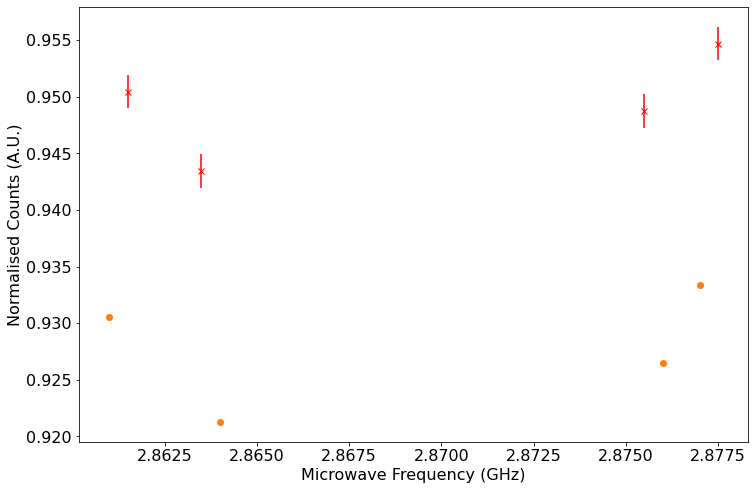

In [129]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
#######

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.

four_point_data_set = '_4_point_referenced_odmr_35' # Short hand for the file name. 

# Set the file names for all 4 data sets recorded from the experiment. 
four_point_file_name_ODMR1 = date + four_point_data_set + '_ODMR1.dat'
four_point_file_name_ODMR2 = date + four_point_data_set + '_ODMR2.dat'
four_point_file_name_Ref1 = date + four_point_data_set  + '_Ref1.dat'
four_point_file_name_Ref2 = date + four_point_data_set  + '_Ref2.dat'

#folder_path_2 = folder_path + 'simulated_temp_change\\'

# Extract the ODMR and reference datasets from the data we are looking at. 
four_point_odmr_data = load_data(folder_path + four_point_file_name_ODMR1)
four_point_reference_data = load_data(folder_path + four_point_file_name_Ref1)

# Get the parameters for the experiment. 
four_point_params_file = load_params(folder_path + date  + four_point_data_set + '_Params.txt')
four_point_params_values = four_point_params_file['Parameter value']
#print(four_point_params_file)
# Reshape the data so that it can be used for the following script. 
four_point_odmr_data, four_point_reference_data = reshape_data(four_point_reference_data, 
                                                               four_point_odmr_data, four_point_params_values)

# Need to have the four_freqs array layered as follows [F1, F2, F3, F4] due to riggering problems in the software.  
four_freqs = [2.8615 ,2.8635, 2.8755, 2.8775]
repeats = four_point_params_values[8]

mean_four_point_intensity = np.mean(four_point_odmr_data, axis = 2)
mean_reference_intensity = np.mean(four_point_reference_data, axis = 2)

# Generate the error arrays for the ODMR and reference data. 
four_points_ODMR_error = 2.2 * np.sqrt(mean_four_point_intensity) # shot noise limit approximation
four_points_reference_error = 2.2 * np.sqrt(mean_reference_intensity) # shot noise limit approximation

print(np.mean(four_point_odmr_data, axis = 2))
print(four_points_ODMR_error)

# Normalise the ODMR data against the reference data. 
norm_odmr_4_point = normalise_data(four_point_reference_data, four_point_odmr_data)
# Mean of the normalise dataset.
mean_odmr_4_point_freq_points, mean_norm_4_point_odmr = mean_data(norm_odmr_4_point)

# Find the error for the normaised dataset. 
norm_ODMR_errors = normalise_data_error_propogation(np.mean(norm_odmr_4_point, axis = 2), 
                                                              four_point_reference_data, four_point_odmr_data,
                                                             repeats)

# roll the values +1 spaces in the array to correct for problems in the measurement regime. 
mean_norm_4_point_odmr = np.roll(mean_norm_4_point_odmr, 1)
norm_ODMR_errors = (np.roll(norm_ODMR_errors, 1))

#plot.plot(freq[45*7:90*7], y_fit[45*7:90*7], color = 'k')
print(freq[1:3])
indices = []
indices.append((np.abs(freq - four_freqs[0])).argmin())
indices.append((np.abs(freq - four_freqs[1])).argmin())
indices.append((np.abs(freq - four_freqs[2])).argmin())
indices.append((np.abs(freq - four_freqs[3])).argmin())

indices = np.array(indices)
print(indices)
plot.scatter(freq[120:160], y_fit[120:160])
plot.scatter(freq[indices], y_fit[indices], marker = 'o')

plot.errorbar(four_freqs, mean_norm_4_point_odmr, norm_ODMR_errors[0], color = 'r', marker = 'x',
             linestyle = '')
plot.xlabel('Microwave Frequency (GHz)')
plot.ylabel('Normalised Counts (A.U.)')


In [130]:
#storage[41,:] = mean_norm_4_point_odmr
#table = pd.DataFrame(storage)

***

### Fujiwara Analysis

***

In [131]:
# Run the Fuijiwara protocol. 

# This protocol outputs the change in resonant frequency of the NV centre in MHz. 
# In addition the temperature change is also outputted from the dataset. assuming a dD/dT of -75kHz/K. 
zumi_dD, zumi_dT, error_zumi_dD, error_zumi_dT  = fujiwara_analysis(four_freqs, mean_norm_4_point_odmr, norm_ODMR_errors[0])

print(zumi_dD, zumi_dT, error_zumi_dD, error_zumi_dT)
print('\n')
try:
    zumi_dD_store.append(zumi_dD)
    zumi_dT_store.append(zumi_dT)
except:
    zumi_dD_store = []
    zumi_dT_store = []
    zumi_dD_store.append(zumi_dD) # MHz
    zumi_dT_store.append(zumi_dT) # Kelvin
    
analysis_type = 'Fujiwara_2020_Thesis_data_'
    
save_data(four_point_data_set, date, four_point_params_values[3]/1000, four_point_params_values[8],
         zumi_dD, np.array(error_zumi_dD), zumi_dT, np.array(error_zumi_dT), np.mean(four_point_reference_data), analysis_type)

#print(zumi_dD_store)
#print(error_zumi_dD)
#print(zumi_dT_store)

-0.7343324876065953 9.791099834754604 -0.4225982113981935 5.63464281864258




In [99]:
(90/75)*np.sqrt(80)

10.73312629199899